## ROC Curves and AUC

Sandbox to experiment with ROC Curves and AUC.

Resources:
- https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077
- https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve.ipynb
- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [88]:
from numpy import argmax
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


### Generate Dataset

To start experimenting with ROC techniques, let's create a synthetic dataset for two classes.

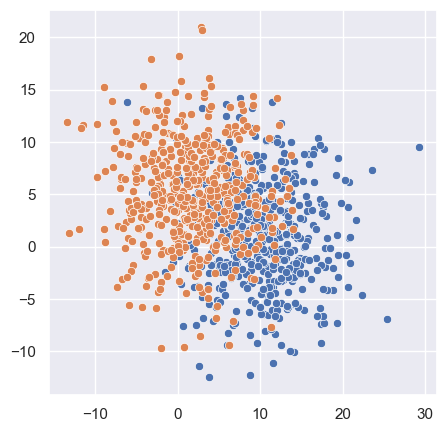

In [73]:
# Parameters
np.random.seed(42)
scale = 5
size = 500

# Generate class 1
class1_x = np.random.normal(loc=10, scale=scale, size=size)
class1_y = np.random.normal(loc=1, scale=scale, size=size)
# Generate class 2
class2_x = np.random.normal(loc=1, scale=scale, size=size)
class2_y = np.random.normal(loc=5, scale=scale, size=size)

# Inspect overlap
plt.figure(figsize=(5, 5))
sns.scatterplot(x=class1_x, y=class1_y)
sns.scatterplot(x=class2_x, y=class2_y)
plt.show()


In [74]:
# Create dataframe
df_class1 = pd.DataFrame()
df_class1['x'] = class1_x
df_class1['y'] = class1_y
df_class1['class'] = 0

df_class2 = pd.DataFrame()
df_class2['x'] = class2_x
df_class2['y'] = class2_y
df_class2['class'] = 1

df = pd.concat([df_class1, df_class2], ignore_index=True)


### Fit Classifier Model

Let's fit a simple classifier model to the data.

In [75]:
# Get dependent and independent variables
X = df.drop(columns=['class'])
y = df['class']


In [76]:
# Test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


              precision    recall  f1-score   support

           0       0.85      0.79      0.82       112
           1       0.76      0.82      0.79        88

    accuracy                           0.81       200
   macro avg       0.80      0.81      0.80       200
weighted avg       0.81      0.81      0.81       200



<Axes: xlabel='x', ylabel='y'>

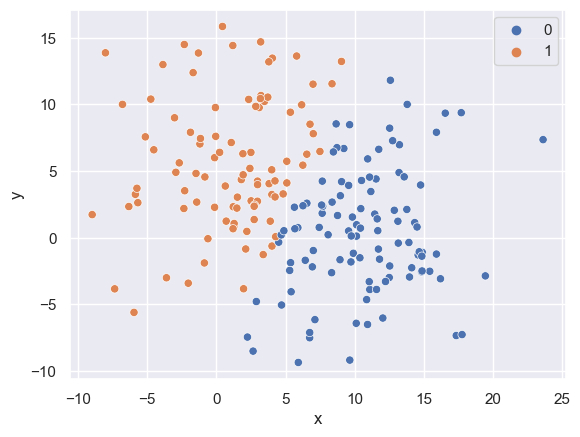

In [77]:
# Fit
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(metrics.classification_report(y_test, model.predict(X_test)))
sns.scatterplot(x=X_test['x'], y=X_test['y'], hue=y_pred)


### ROC Curve

We're now ready to generate the ROC Curve and AUC.

In [78]:
# Get probabilities for each class
y_proba = model.predict_proba(X_test)
y_proba[:5]


array([[0.00423155, 0.99576845],
       [0.09333391, 0.90666609],
       [0.95521178, 0.04478822],
       [0.05186794, 0.94813206],
       [0.95565197, 0.04434803]])

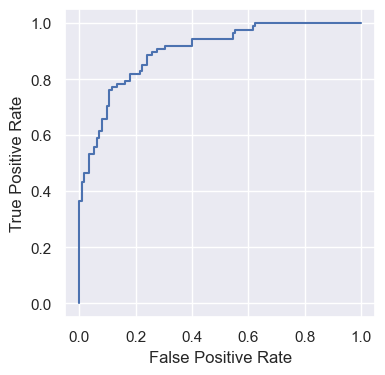

In [79]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1], pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_display.figure_.set_size_inches(4, 4)


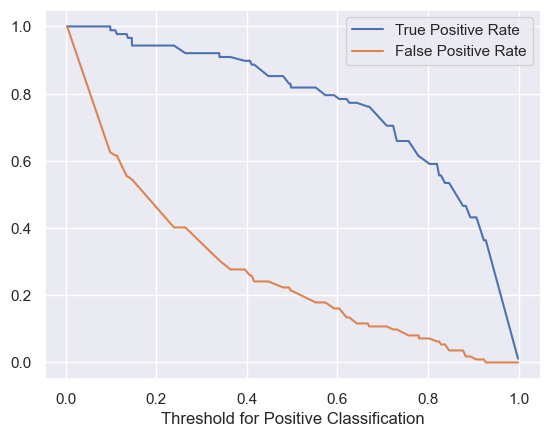

In [80]:
# Explore thresholds
plt.plot(thresholds[1:], tpr[1:], label='True Positive Rate')
plt.plot(thresholds[1:], fpr[1:], label='False Positive Rate')
plt.xlabel('Threshold for Positive Classification')
plt.legend()
plt.show()


In [81]:
# AUC
print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")


AUC: 0.8064


### Determine Best Threshold

Let's look at one way to compute the "best" threshold that provides an optimal balance between false positive and true positive rates. The technique used here is [Youden's J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic).

In [82]:
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold: {best_thresh:.3f}')


Best Threshold: 0.643


### Implement Optimal Threshold into Model

After determining an optimal classification threshold, the next step is to implement that threshold into the prediction model. To do that we'll create a custom transformer.

In [93]:
class ClassifierThreshold(BaseEstimator, RegressorMixin):
    """Classifier with selectable threshold level"""

    def __init__(self, classifier, threshold):
        self.classifier = classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.classifier.fit(X, y)
        return self

    def predict(self, X):
        proba = self.classifier.predict_proba(X)[:, 1]
        y_pred = np.where(proba > self.threshold, 1, 0)
        return y_pred


In [99]:
# Fit custom classifier model
model = ClassifierThreshold(LogisticRegression(), threshold=0.643)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(metrics.classification_report(y_test, model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.82      0.88      0.85       112
           1       0.84      0.76      0.80        88

    accuracy                           0.83       200
   macro avg       0.83      0.82      0.83       200
weighted avg       0.83      0.83      0.83       200



By updating the model to use the more optimal threshold level, the overall accuracy on the test data increased 2%. 

### Precision-Recall Curve

It's worth looking at the precision-recall curve to highlight the differences. Unlike the ROC curve, the precision-recall curve is focused on the classifier model's performance on the positive class only.

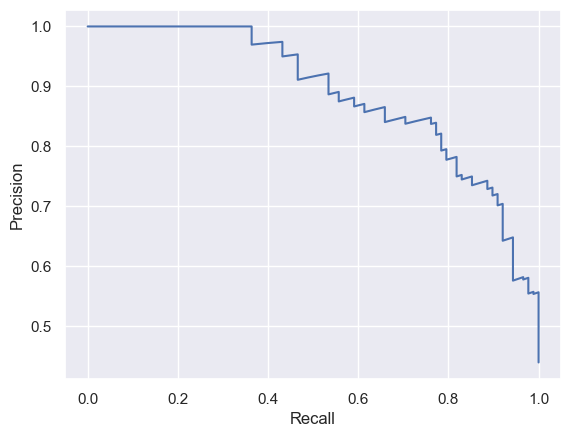

In [87]:
precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba[:, 1], pos_label=1)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
